<a href="https://colab.research.google.com/github/renaud-florquin/hands_on_AI/blob/master/Intro2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


In [2]:
print(torch.cuda.is_available())

True


In [0]:
# hyperparameters
input_size = 784
output_size = 10
hidden_size = 32

epochs = 100
batch_size = 50
learning_rate = 0.0001

Create loader to train and test

In [0]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('tmp/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('tmp/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

Access to the train loader to see the data and format

In [0]:
x, y = train_loader.__iter__().__next__()

In [12]:
x.shape, y.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

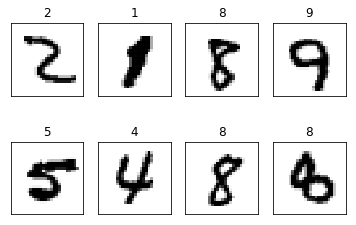

In [18]:
amount = 20
img_rows = 2
img_columns = 4
amount = img_rows * img_columns
fig = plt.figure()

for i in range(amount):
    ax = fig.add_subplot(img_rows, img_columns, 1 + i)
    plt.imshow(x[i][0], cmap='binary')
    plt.title(y[i].item())
    plt.xticks([]) 
    plt.yticks([])

plt.show()

Neural network definition

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, output_size)
        
    def forward(self, x):
        z = x.view(-1, 1*28*28)
        z = self.layer1(z)
        z = F.relu(z)
        z = self.layer2(z)
        z = F.relu(z)
        z = self.layer3(z)
        return F.log_softmax(z)

In [50]:
net = Network()
print(net)

Network(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
)


In [0]:
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [0]:
train_losses = []
test_losses = []
test_accuracies = []

def train_network(epoch):
    net.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        output = net(x)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    return loss


In [0]:
def print_info(epoch, loss):
    print('Train Epoch: {} \tLoss: {:.6f}'.format(
      epoch, loss.item()))
    train_losses.append(loss.item())

def save_model_state():
    torch.save(net.state_dict(), 'model.pth')
    torch.save(optimizer.state_dict(), 'optimizer.pth')

In [0]:
def test_network():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            output = net(x)
            test_loss += F.nll_loss(output, y, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(y.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))


In [55]:
for e in range(10):
        loss = train_network(e+1)
        test_network()
        #print_info(e+1, loss)
        save_model_state()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.8977, Accuracy: 6193/10000 (61%)


Test set: Avg. loss: 1.0010, Accuracy: 7897/10000 (78%)


Test set: Avg. loss: 0.6160, Accuracy: 8497/10000 (84%)


Test set: Avg. loss: 0.4813, Accuracy: 8736/10000 (87%)


Test set: Avg. loss: 0.4156, Accuracy: 8864/10000 (88%)


Test set: Avg. loss: 0.3781, Accuracy: 8954/10000 (89%)


Test set: Avg. loss: 0.3518, Accuracy: 9008/10000 (90%)


Test set: Avg. loss: 0.3330, Accuracy: 9050/10000 (90%)


Test set: Avg. loss: 0.3189, Accuracy: 9077/10000 (90%)


Test set: Avg. loss: 0.3065, Accuracy: 9113/10000 (91%)



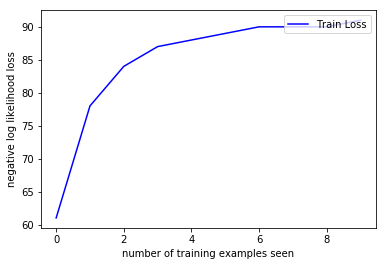

In [56]:
plt.plot(range(10), test_accuracies, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

plt.show()